# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('parsed_reviews3.csv', sep = ',', encoding='utf-8')
data['rating'] = data['rating'].astype(int)
data['date'] = pd.to_datetime(data['date'])
data

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36
...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32


In [8]:
# топ-5 банков по числу отзывов
# banks_reviews_count = data['bank_name'].value_counts().reset_index()
banks_reviews_and_rating = data.groupby(['bank_name']).agg({'body':'count', 'rating': 'mean'}).reset_index()
banks_reviews_and_rating.columns = ['bank_name', 'count', 'rating']
banks_reviews_and_rating.sort_values(by='count', ascending=False, inplace=True)
top15_banks_by_count = banks_reviews_and_rating.head(15).reset_index(drop=True)
top15_banks_by_count

,bank_name,count,rating
0,Тинькофф Банк,44864,4.783568
1,Хоум Кредит Банк,9310,4.505585
2,Совкомбанк,6111,4.264768
3,ВТБ,3817,1.950223
4,СберБанк,3490,2.303725
5,Альфа-Банк,3369,1.714159
6,Россельхозбанк,3064,4.455940
7,Банк Открытие,1894,3.543295
8,МТС Банк,1542,2.901427
9,Модульбанк,1460,4.780137


In [9]:
top1_bank_by_rating = top15_banks_by_count.sort_values(by='rating', ascending=False).head(1)
top1_bank_by_rating

,bank_name,count,rating
0,Тинькофф Банк,44864,4.783568


In [14]:
# data['year_month'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')
data['month'] = pd.to_datetime(data['date']).dt.strftime('%m')
# эти данные понадобятся позже
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['second'] = data['date'].dt.second

In [15]:
# data_to_graph = data[data['bank_name'].isin(top5_banks['bank_name'])].groupby(['bank_name', 'month']).mean()
data_to_graph = data[['bank_name','month','rating']]
data_to_graph = data_to_graph[data_to_graph['bank_name'].isin(top15_banks_by_count.head(5)['bank_name'])].groupby(['bank_name', 'month']).agg({'rating': 'mean'}).reset_index()
data_to_graph['rating'] = data_to_graph['rating'].round(2)
data_to_graph.head(10)

,bank_name,month,rating
0,ВТБ,01,1.15
1,ВТБ,09,2.07
2,ВТБ,10,1.91
3,ВТБ,11,1.99
4,ВТБ,12,1.90
5,СберБанк,01,1.40
6,СберБанк,09,1.92
7,СберБанк,10,2.78
8,СберБанк,11,2.56
9,СберБанк,12,1.87


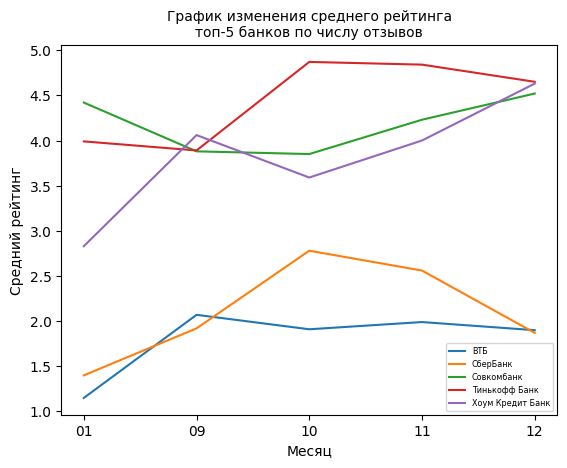

In [16]:
banks = data_to_graph['bank_name'].unique()

# plt.figure(figsize=(8, 5))
for b in banks:
    bank_data = data_to_graph[data_to_graph['bank_name'] == b]
    plt.plot(bank_data['month'], bank_data['rating'], label=b)

plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.legend(fontsize='xx-small', loc='lower right')
plt.show()


Выводы:

Теперь проанализируем временные данные

In [ ]:
hour_data = data.groupby(['hour']).count().reset_index().iloc[:, :2]
hour_data.head(5)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(hour_data['hour'], hour_data['body'])
plt.title('График зависимости количества отзывов от времени суток', fontsize=10)
plt.xlabel('Час')
plt.ylabel('Количество отзывов')
plt.show()

In [ ]:
hour_rating_data = data.groupby(['hour']).agg({'rating': 'mean'}).reset_index()

In [ ]:
plt.plot(hour_rating_data['hour'], hour_rating_data['rating'])
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Час')
plt.ylabel('Количество отзывов')
plt.show()

А сейчас минутка nlp

In [44]:
import nltk
from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")
from nltk.tokenize import sent_tokenize, word_tokenize
import pymorphy3
from nltk.stem import SnowballStemmer

In [45]:
from bs4 import BeautifulSoup
import re
def preprocess(data):
    cleaned_body = []
    morph = pymorphy3.MorphAnalyzer()
    for b in data['body']:
        soup = BeautifulSoup(b, 'html.parser')
        text = soup.get_text()
        b = re.findall(r'<p>(.*?)<\/p>', text)
        if not b:
            b = text
        b = ''.join(b).lower()
        words = re.findall(r'\b\w+\b', b)
        processed_words = []
        for w in words:
            if w.isalpha() and len(w) > 1 and w not in ru_stopwords:
                w = w.strip()
                try:
                    w = morph.parse(w)[0].normal_form
                    processed_words.append(w)
                except:
                    processed_words.append(w)

        cleaned_body.append(' '.join(processed_words))
    data['cleaned_body'] = cleaned_body
    return data
preprocess(data)

C:\Users\mayko\AppData\Local\Temp\ipykernel_17944\3799386097.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(b, 'html.parser')


,body,title,rating,bank_name,date,month,day,hour,minute,second,cleaned_body
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,01,3,12,46,11,добрый деньписать сюда скорый разрешение вопро...
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,01,3,12,31,46,возврат просрочить задолженность банк звонить ...
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,01,3,12,23,11,оформить кредитный карта день банк открытие по...
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,01,3,12,16,7,новый год начинаться приятность понимать челов...
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,01,3,12,12,36,увидеть сайт газпромбанк акция бонус кредитный...
...,...,...,...,...,...,...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44,09,2,11,47,44,август обнаружить баланс уменьшиться история о...
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24,09,2,11,46,24,обратиться вопрос all airlines заказать первый...
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34,09,2,11,34,34,август досрочно погасить ипотека кредитный дог...
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32,09,2,11,28,32,оформить кредит покупка автомобиль салон станц...


In [ ]:
def preprocess(df):
    lemmatizer = WordNetLemmatizer()
    stop_words = list(set(stopwords.words('english')))#.extend(['http', 'co'])
    stop_words += ['http', 'https','co']

    preprocessed_texts = []
    for text in df['text']:

        text = re.sub('[^a-zA-Z]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        tokens = word_tokenize(text.lower())

        lemmas = [lemmatizer.lemmatize(token) for token in tokens if (token not in stop_words + punctuation_marks)]
        no_single_lemmas = []
        for lemma in lemmas:
            if len(lemma) > 1:
                no_single_lemmas.append(lemma)
        preprocessed_texts.append(' '.join(no_single_lemmas))
    try:
      preprocessed_df = pd.DataFrame({'text': preprocessed_texts, 'target': df['target']})
    except KeyError:
      preprocessed_df = pd.DataFrame({'text': preprocessed_texts, 'target': ''})
    return preprocessed_df